In [1]:
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
import torch

Lets dynamically choose type of device to use for our computations. To run on your own GPU one needs to install pytorch and cuda-toolkit.

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

False
cpu


Define the seed for reproductivity:

In [3]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

**Image loading and resizing**

We have choosen 256x256

In [4]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Path to the directory contains images
images_dir = "data/images"

# List all image filenames in the directory
image_filenames = os.listdir(images_dir)

# Create an empty list to store the images
images = []

# Load images as NumPy arrays and store them in the list
for filename in tqdm(image_filenames):
    image_path = os.path.join(images_dir, filename)
    if os.path.isfile(image_path):  # Check if it's a file, not a directory (to avoid the notebook checkpoints)
        image = Image.open(image_path)

        # Resize images
        target_size = (256, 256)
        image = image.resize(target_size, Image.LANCZOS)
        
        # Convert image to array
        image_array = np.array(image)
        images.append(image_array)

# Convert the list of arrays to a single NumPy array
images = np.array(images)

100%|██████████| 1000/1000 [00:10<00:00, 91.12it/s]


In [5]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Path to the directory containing masks in your Google Drive
masks_dir = "data/masks"

# List all mask filenames in the directory
mask_filenames = os.listdir(masks_dir)

# Create an empty list to store the masks
masks = []

# Load masks as NumPy arrays and store them in the list
for filename in tqdm(mask_filenames):
    mask_path = os.path.join(masks_dir, filename)
    if os.path.isfile(mask_path):  # Check if it's a file, not a directory (to avoid the notebook checkpoints)
        mask = Image.open(mask_path)
    
        # Resize masks to the same size as images
        target_size = (256, 256)
        mask = mask.resize(target_size, Image.LANCZOS)
    
        # Convert mask to array
        mask_array = np.array(mask)
    
        masks.append(mask_array)

# Convert the list of arrays to a single NumPy array
masks = np.array(masks)

100%|██████████| 1000/1000 [00:06<00:00, 148.45it/s]


**Data augmentation**

In [20]:
import numpy as np
from tqdm import tqdm
import albumentations as A

# Define Albumentations transformations
transformations = A.Compose(
        [
            A.OneOrOther(
                A.Compose([A.RandomRotate90(), A.OneOf([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)])]),
                A.Compose([A.Rotate(p=0.5), A.OneOf([A.HueSaturationValue(p=0.5), A.RGBShift(p=0.7)], p=1)]),
            ),
            A.HorizontalFlip(p=1),
            A.RandomBrightnessContrast(p=0.5)
        ])

# Create lists for storing the augmented images and masks
augmented_images = []
augmented_masks = []

# Number of times to apply augmentation for each image
num_augmentations = 3

# Apply transformations
for image, mask in tqdm(zip(images, masks), total=images.shape[0]):
    for _ in range(num_augmentations):
        # Apply Albumentations transformations
        augmented = transformations(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented images
combined_images = np.concatenate([images, augmented_images], axis=0)
combined_masks = np.concatenate([masks, augmented_masks], axis=0)

# Save them in the data folder
np.save("data/augmented/combined_images.npy", combined_images)
np.save("data/augmented/combined_masks.npy", combined_masks)


100%|██████████| 1000/1000 [00:07<00:00, 141.08it/s]


In [21]:
print("number of total images", len(combined_images))
print("number of total masks",len(combined_masks))

number of total images 4000
number of total masks 4000


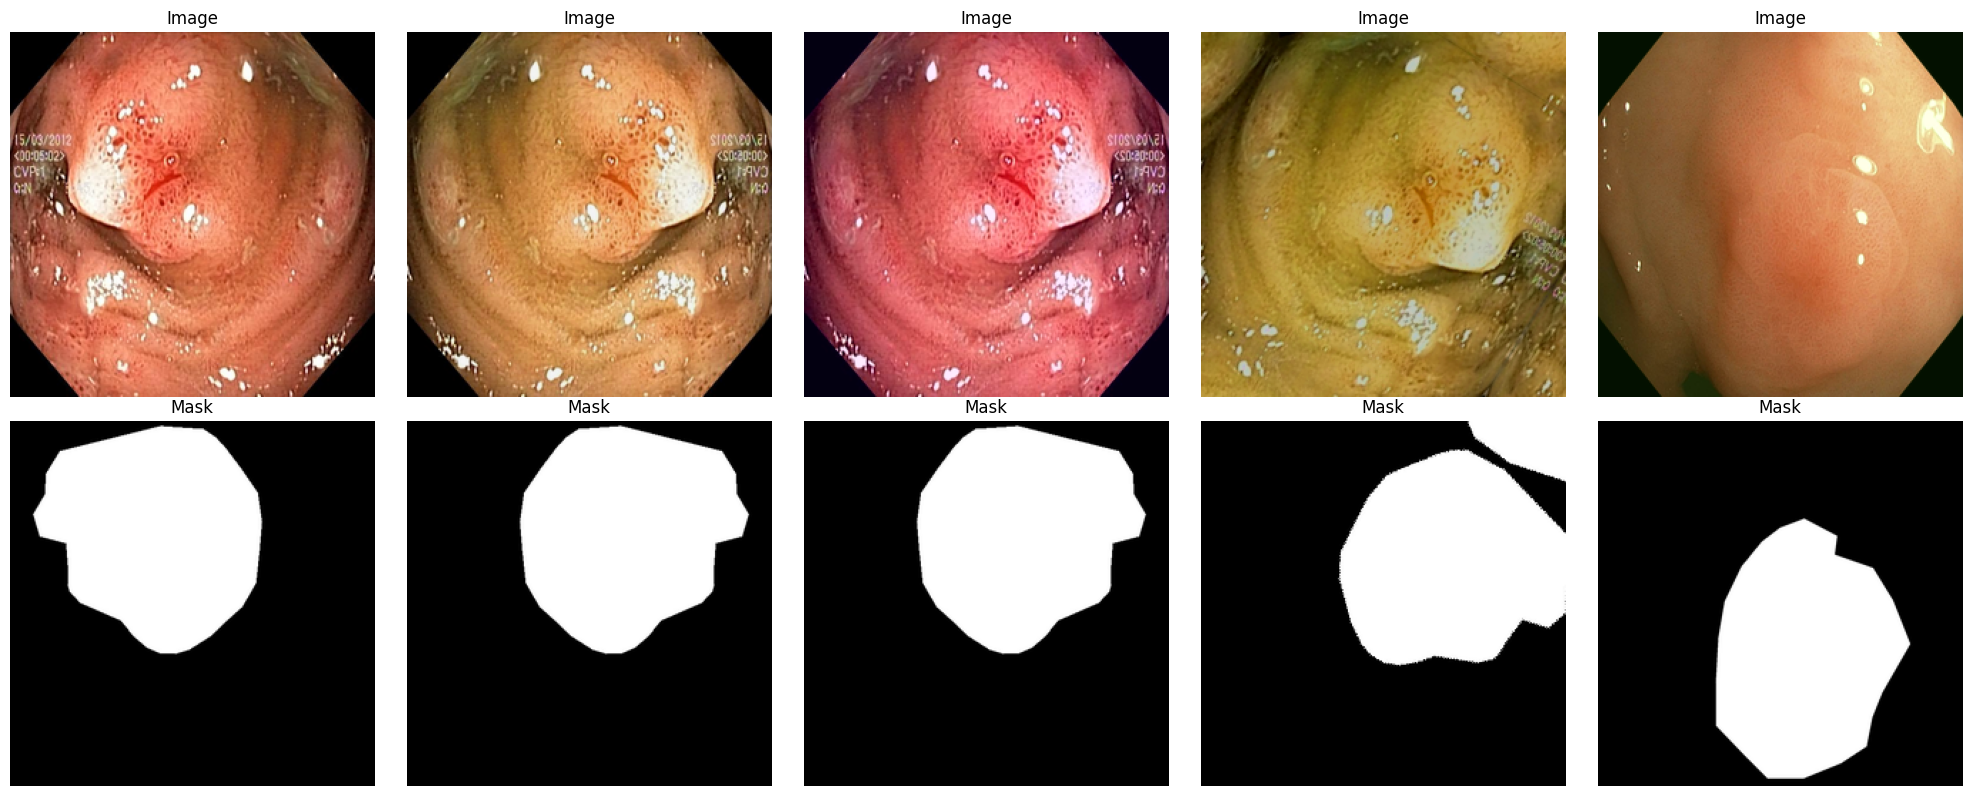

In [22]:
import matplotlib.pyplot as plt
import random

# Select 5 random indices
#random_indices = random.sample(range(len(combined_images)), 5)
random_indices = [0,1000,1001,1002, 1003]
# Create a subplot with a grid view to display images and masks
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot the 5 random images with their corresponding masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(combined_images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis('off')

    # Plot the mask
    axes[1, i].imshow(combined_masks[idx], cmap='gray')  # No need to specify cmap for grayscale masks
    axes[1, i].set_title("Mask")
    axes[1, i].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


**Standaritzation**

In [23]:
mean = np.mean(combined_images, axis = (0,1,2)) / 255
std = np.std(combined_images, axis = (0,1,2)) / 255

print("-----  NORMALIZATION VALUES  -----")
print(f"Mean (RGB): {mean}")
print(f"Standard Deviation (RGB): {std}")

-----  NORMALIZATION VALUES  -----
Mean (RGB): [0.56399276 0.33202926 0.2465689 ]
Standard Deviation (RGB): [0.3123053  0.23121322 0.19635625]


In [24]:
import torchvision
import torchvision.transforms as transforms

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize it between [0, 1]
    torchvision.transforms.Normalize(mean, std)  # Normalize the tensor using the provided mean and standard deviation
])

**Data splitting**



*   Train-test split (70/30)
*   Train-validation split

*comment: this will need to be done in the training notebooks, not here*



In [25]:
from sklearn.model_selection import train_test_split
from src.preprocess import KvasirDataset

# Split the dataset into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    combined_images, combined_masks, test_size=0.3, random_state=42)

# Print the shapes of the train and test sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train masks shape:", train_masks.shape)
print("Test masks shape:", test_masks.shape)

# Create KvasirDataset objects for train and test sets
train_dataset = KvasirDataset(images=train_images, masks=train_masks, transforms=transforms)
test_dataset = KvasirDataset(images=test_images, masks=test_masks, transforms=None)  # No transformations for the test set


Train images shape: (2800, 256, 256, 3)
Test images shape: (1200, 256, 256, 3)
Train masks shape: (2800, 256, 256, 3)
Test masks shape: (1200, 256, 256, 3)


In [26]:
#Validation set (10%)
training_images, val_images, training_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42)
# Check shape of training images and masks
print("Training Images Shape:", training_images.shape)
print("Training Masks Shape:", training_masks.shape)

# Check shape of validation images and masks
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)

# Check length of training and validation sets
print("Number of Training Examples:", len(training_images))
print("Number of Validation Examples:", len(val_images))

val_dataset = KvasirDataset(images=val_images,masks=val_masks, transforms=None)

Training Images Shape: (2520, 256, 256, 3)
Training Masks Shape: (2520, 256, 256, 3)
Validation Images Shape: (280, 256, 256, 3)
Validation Masks Shape: (280, 256, 256, 3)
Number of Training Examples: 2520
Number of Validation Examples: 280


In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE =64

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_iterator = DataLoader(val_dataset,batch_size=BATCH_SIZE)